In [ ]:
import numpy as np
import pandas as pd
import plotly.express as px
from sklearn.preprocessing import MaxAbsScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from keras.models import Sequential
from keras.layers import LSTM, Dense, Dropout, Conv1D, MaxPooling1D, GRU, Flatten
from sklearn.model_selection import TimeSeriesSplit
import plotly.graph_objects as go

In [ ]:
data2 = pd.read_csv("../data/PV_panel_power_with_weather_hour.csv", delimiter=";")
data = data2.copy(deep=True)
data = data.drop(["MODELICA", 'MODELICA_ERROR', 'SHADOW'], axis=1)
# df = data.copy(deep=True)
data['DATE'] = pd.to_datetime(data['DATE'])

In [ ]:
# Extracting seasonal information
data.set_index('DATE', inplace=True)
data['MONTH'] = data.index.month
data['DAY_OF_YEAR'] = data.index.dayofyear
data['WEEK_OF_YEAR'] = data.index.isocalendar().week
data['DAY_OF_WEEK'] = data.index.dayofweek
data['HOUR'] = data.index.hour

# Selecting relevant columns for modeling
selected_features = ['IRRADIANCE_SOLAR', 'AIR_TEMPERATURE_CELSIUS', 'DIRECTION_WIND', 'IGRO', 'VELOCITY_WIND', 'RAFF_WIND', 'PV_Power',
            'MONTH', 'DAY_OF_YEAR', 'WEEK_OF_YEAR', 'DAY_OF_WEEK', 'HOUR']

data = data[selected_features].dropna()

# Smoothing all data
data = data.rolling(window=32, min_periods=1).mean()

In [ ]:
data

,IRRADIANCE_SOLAR,AIR_TEMPERATURE_CELSIUS,DIRECTION_WIND,IGRO,VELOCITY_WIND,RAFF_WIND,PV_Power,MONTH,DAY_OF_YEAR,WEEK_OF_YEAR,DAY_OF_WEEK,HOUR
DATE,,,,,,,,,,,,
2016-02-18 00:00:00,0.00000,3.00000,350.000000,100.00000,1.00000,3.200000,0.00000,2.0,49.00000,7.0,3.00000,0.00
2016-02-18 01:00:00,0.00000,3.00000,350.000000,100.00000,1.00000,3.200000,0.00000,2.0,49.00000,7.0,3.00000,0.50
2016-02-18 02:00:00,0.00000,3.00000,234.666667,100.00000,1.00000,3.166667,0.00000,2.0,49.00000,7.0,3.00000,1.00
2016-02-18 03:00:00,0.00000,3.00000,265.000000,100.00000,1.00000,3.025000,0.00000,2.0,49.00000,7.0,3.00000,1.50
2016-02-18 04:00:00,0.00000,3.00000,215.400000,100.00000,1.00000,2.940000,0.00000,2.0,49.00000,7.0,3.00000,2.00
...,...,...,...,...,...,...,...,...,...,...,...,...
2018-11-02 19:00:00,82.34375,9.84375,169.937500,88.78125,1.06250,3.050000,1890.00000,11.0,305.62500,44.0,3.62500,12.50
2018-11-02 20:00:00,69.68750,9.84375,176.468750,89.28125,1.06250,3.043750,1610.00000,11.0,305.65625,44.0,3.65625,12.75
2018-11-02 21:00:00,52.59375,9.81250,173.218750,89.90625,1.03125,3.009375,1320.84375,11.0,305.68750,44.0,3.68750,13.00


In [ ]:
fig = px.line(data['PV_Power'], title='Smoothed Daily PV Power Production')
fig.update_layout(xaxis_title='Date', yaxis_title='PV Power')
fig.show()

# Scaling the data using MaxAbsScaler
scaler = MaxAbsScaler()
scaled_series = scaler.fit_transform(data)

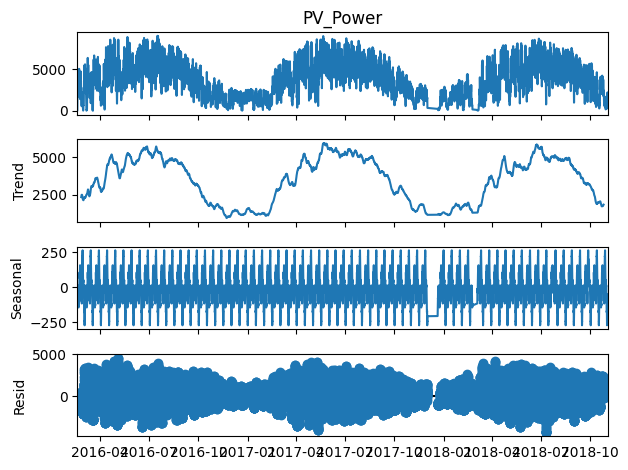

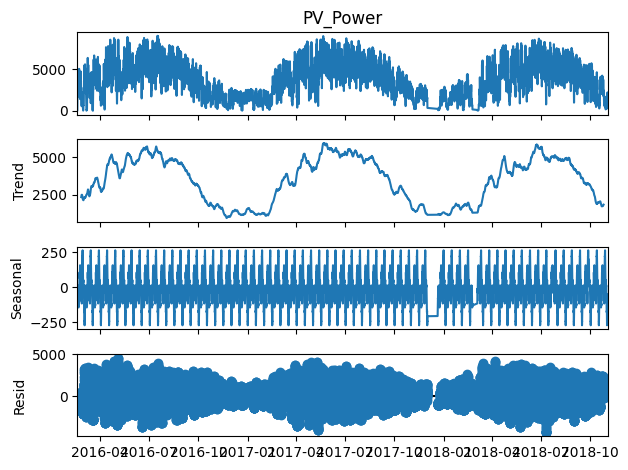

In [ ]:
from statsmodels.tsa.seasonal import seasonal_decompose

seasonal_decompose(data['PV_Power'], model='additive', period=365).plot()

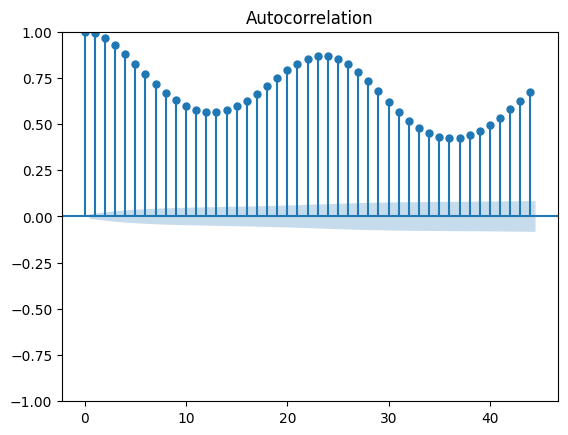

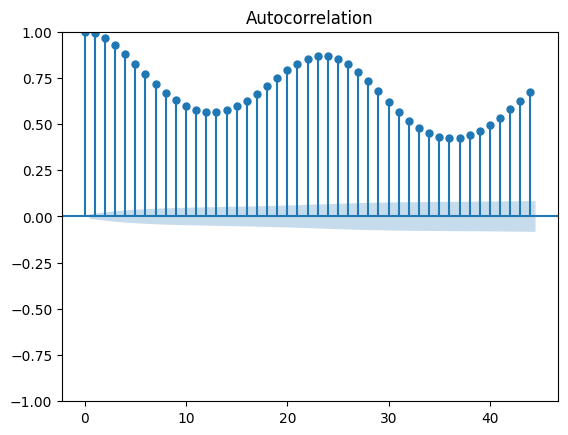

In [ ]:
from statsmodels.graphics.tsaplots import plot_acf

plot_acf(data['PV_Power'])

In [ ]:
def create_dataset(data, time_step=12, pv_power_index= 6):
    X, y = [], []
    for i in range(len(data) - time_step - 1):
        X.append(data[i:(i + time_step)])
        y.append(data[i + time_step, pv_power_index])
    return np.array(X), np.array(y)

time_step = 12
X, y = create_dataset(scaled_series, time_step, pv_power_index = data.columns.get_loc('PV_Power') )

# Reshaping X for input
X = X.reshape(X.shape[0], X.shape[1], X.shape[2])

# TimeSeries cross-validator (k-fold)
tscv = TimeSeriesSplit(n_splits=5)

# Model definitions to try
def build_lstm(input_shape):
    model = Sequential()
    model.add(LSTM(50, return_sequences=True, input_shape=input_shape))
    model.add(Dropout(0.2))
    model.add(LSTM(50, return_sequences=False))
    model.add(Dropout(0.2))
    model.add(Dense(1))
    return model

def build_stacked_lstm(input_shape):
    model = Sequential()
    model.add(LSTM(50, return_sequences=True, input_shape=input_shape))
    model.add(LSTM(50, return_sequences=True))
    model.add(Dropout(0.2))
    model.add(LSTM(50, return_sequences=False))
    model.add(Dropout(0.2))
    model.add(Dense(1))
    return model

def build_cnn_1d(input_shape):
    model = Sequential()
    model.add(Conv1D(filters=64, kernel_size=2, activation='relu', input_shape=input_shape))
    model.add(MaxPooling1D(pool_size=2))
    model.add(Flatten())
    model.add(Dense(50, activation='relu'))
    model.add(Dense(1))
    return model

def build_gru(input_shape):
    model = Sequential()
    model.add(GRU(50, return_sequences=True, input_shape=input_shape))
    model.add(Dropout(0.2))
    model.add(GRU(50, return_sequences=False))
    model.add(Dropout(0.2))
    model.add(Dense(1))
    return model

models = {
    '1D CNN': build_cnn_1d,
    'LSTM': build_lstm,
    'Stacked LSTM': build_stacked_lstm,
    'GRU': build_gru
}

In [ ]:
all_y_tests = {}
all_y_preds = {}

# Iterate over different models
for model_name, model_builder in models.items():
    print(f"\nTraining {model_name} model...")
    mse_list, rmse_list, mae_list, r2_list = [], [], [], []
    all_y_test, all_y_pred = [], []

    for train_index, test_index in tscv.split(X):
        X_train, X_test = X[train_index], X[test_index]
        y_train, y_test = y[train_index], y[test_index]

        # Model definition
        model = model_builder((time_step, X.shape[2]))
        model.compile(optimizer='adam', loss='mean_squared_error')

        # Model training
        model.fit(X_train, y_train, epochs=50, batch_size=32, verbose=0)

        # Predictions
        y_pred = model.predict(X_test)

        # Metrics calculation
        mse = mean_squared_error(y_test, y_pred)
        rmse = np.sqrt(mse)
        mae = mean_absolute_error(y_test, y_pred)
        r2 = r2_score(y_test, y_pred)

        mse_list.append(mse)
        rmse_list.append(rmse)
        mae_list.append(mae)
        r2_list.append(r2)

        all_y_test.extend(y_test)
        all_y_pred.extend(y_pred.flatten())

    # Store true and predicted values for plotting
    all_y_tests[model_name] = all_y_test
    all_y_preds[model_name] = all_y_pred

    # Printing metrics for each fold
    for i in range(len(mse_list)):
        print(f"{model_name} - Fold {i+1} - MSE: {mse_list[i]}, RMSE: {rmse_list[i]}, MAE: {mae_list[i]}, R2: {r2_list[i]}")

    # Calculating and printing mean and standard deviation of metrics
    print(f"\n{model_name} - Average Metrics and Standard Deviations:")
    print(f"MSE: Mean = {np.mean(mse_list)}, Std = {np.std(mse_list)}")
    print(f"RMSE: Mean = {np.mean(rmse_list)}, Std = {np.std(rmse_list)}")
    print(f"MAE: Mean = {np.mean(mae_list)}, Std = {np.std(mae_list)}")
    print(f"R2: Mean = {np.mean(r2_list)}, Std = {np.std(r2_list)}")


Training 1D CNN model...


/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.



120/120 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step


/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.



120/120 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.



120/120 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.



120/120 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.



120/120 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
1D CNN - Fold 1 - MSE: 0.0014847537542620115, RMSE: 0.03853250256941549, MAE: 0.028288670963583513, R2: 0.9593836723199375
1D CNN - Fold 2 - MSE: 0.0002699095060908217, RMSE: 0.016428922852421632, MAE: 0.012603472575450362, R2: 0.9948561706862183
1D CNN - Fold 3 - MSE: 0.0001530390158162124, RMSE: 0.012370893897217468, MAE: 0.008479904811945143, R2: 0.9961245044022382
1D CNN - Fold 4 - MSE: 0.0002236895621620976, RMSE: 0.014956254951093125, MAE: 0.011877495136521653, R2: 0.9939510343887119
1D CNN - Fold 5 - MSE: 0.00017346508299688742, RMSE: 0.013170614374314034, MAE: 0.009003440717895852, R2: 0.9955918921756985

1D CNN - Average Metrics and Standard Deviations:
MSE: Mean = 0.0004609713842656061, Std = 0.0005135016771766119
RMSE: Mean = 0.01909183772889235, Std = 0.009822072917630407
MAE: Mean = 0.014050596841079307, Std = 0.007294459390409882
R2: Mean = 0.9879814547945609, Std = 0.014317533136913639

Training LSTM model...


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.



120/120 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.



120/120 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.



120/120 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.



120/120 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.



120/120 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
LSTM - Fold 1 - MSE: 0.0004296500981304104, RMSE: 0.020728002753049084, MAE: 0.017847316971499983, R2: 0.9882466643890659
LSTM - Fold 2 - MSE: 8.650723661619158e-05, RMSE: 0.009300926653629282, MAE: 0.007044691346866857, R2: 0.9983513790751376
LSTM - Fold 3 - MSE: 9.536756040779571e-05, RMSE: 0.009765631592876915, MAE: 0.007686215854487216, R2: 0.9975849520557977
LSTM - Fold 4 - MSE: 9.46526585823257e-05, RMSE: 0.00972895978932618, MAE: 0.006856153521094312, R2: 0.9974404229180502
LSTM - Fold 5 - MSE: 7.468589897490376e-05, RMSE: 0.008642100379821086, MAE: 0.006466439890368276, R2: 0.9981020762798576

LSTM - Average Metrics and Standard Deviations:
MSE: Mean = 0.0001561726905423254, Std = 0.00013694177106699236
RMSE: Mean = 0.01163312423374051, Std = 0.004565425621416334
MAE: Mean = 0.009180163516863328, Std = 0.00435148223929273
R2: Mean = 0.9959450989435817, Std = 0.003863515029326417

Training Stacked LSTM model...


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.



120/120 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.



120/120 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.



120/120 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.



120/120 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.



120/120 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step
Stacked LSTM - Fold 1 - MSE: 0.00027853553541412157, RMSE: 0.01668938391355779, MAE: 0.013601248703634458, R2: 0.9923804937051365
Stacked LSTM - Fold 2 - MSE: 0.00011083937246960162, RMSE: 0.010528027947797327, MAE: 0.008633885583385377, R2: 0.997887666790667
Stacked LSTM - Fold 3 - MSE: 0.0004535956655611527, RMSE: 0.021297785461431257, MAE: 0.02041968609086706, R2: 0.9885133343567944
Stacked LSTM - Fold 4 - MSE: 7.114753033179918e-05, RMSE: 0.008434899544855242, MAE: 0.006668332302323048, R2: 0.9980760436019216
Stacked LSTM - Fold 5 - MSE: 0.00016480043145374133, RMSE: 0.01283746203319571, MAE: 0.011128834219378169, R2: 0.9958120789568208

Stacked LSTM - Average Metrics and Standard Deviations:
MSE: Mean = 0.00021578370704608327, Std = 0.00013785829749467796
RMSE: Mean = 0.013957511780167464, Std = 0.004579472890253821
MAE: Mean = 0.012090397379917623, Std = 0.004773480687499857
R2: Mean = 0.9945339234822679, Std = 0.0036417754944703023

Train

/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.



120/120 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.



120/120 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.



120/120 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.



120/120 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.



120/120 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
GRU - Fold 1 - MSE: 0.0003108548926052535, RMSE: 0.017631077465806038, MAE: 0.01369852186158385, R2: 0.9914963783437064
GRU - Fold 2 - MSE: 0.00016149019868148557, RMSE: 0.012707879393568605, MAE: 0.009805832946452212, R2: 0.9969223832465288
GRU - Fold 3 - MSE: 0.0002374387559504107, RMSE: 0.015409047859955874, MAE: 0.013994613813381594, R2: 0.9939872009205226
GRU - Fold 4 - MSE: 0.00013791784007320302, RMSE: 0.011743842645114206, MAE: 0.010188561417162505, R2: 0.9962704550729936
GRU - Fold 5 - MSE: 9.580301628513693e-05, RMSE: 0.00978790152612586, MAE: 0.007867875725664168, R2: 0.9975654464957321

GRU - Average Metrics and Standard Deviations:
MSE: Mean = 0.00018870094071909795, Std = 7.648050045928477e-05
RMSE: Mean = 0.013455949778114118, Std = 0.002763757639151559
MAE: Mean = 0.011111081152848864, Std = 0.002369924345270572
R2: Mean = 0.9952483728158967, Std = 0.002230865776731147


In [ ]:
def plot_predictions(dates, actual_values, all_y_preds, window=5):
    """
    Plot comparison of actual and predicted values for each model.

    Args:
        dates (list): List of dates corresponding to the actual and predicted values.
        actual_values (list): List of actual values for the test set.
        all_y_preds (dict): Dictionary of predicted values for each model (model name -> y_pred list).
        window (int): Window size for smoothing the actual and predicted values.

    Returns:
        None
    """
    fig = go.Figure()
    # Smoothing actual values using rolling mean
    actual_smooth = pd.Series(actual_values).rolling(window=window).mean()

    # Adding actual values to the plot
    fig.add_trace(go.Scatter(
        x=dates,
        y=actual_smooth,
        mode='lines',
        name='Actual Values',
        line=dict(dash='dot')
    ))

    for model_name in all_y_preds.keys():
        # Smoothing predicted values using rolling mean
        y_pred_smooth = pd.Series(all_y_preds[model_name]).rolling(window=window).mean()

        # Adding predicted values to the plot
        fig.add_trace(go.Scatter(
            x=dates,
            y=y_pred_smooth,
            mode='lines',
            name=f'{model_name} - Predictions'
        ))

    fig.update_layout(
        title='Comparison of Actual and Predicted Values',
        xaxis_title='Date',
        yaxis_title='Scaled P-Power',
        legend_title='Models',
        template='plotly_white'
    )
    fig.show()

In [ ]:
dates = data2['DATE'][-len(y):]
plot_predictions(dates, all_y_tests['LSTM'], all_y_preds, window=1024)

Output hidden; open in https://colab.research.google.com to view.